In [ ]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

In [8]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

In [3]:
train_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
train_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [4]:
test_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
test_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [5]:
# Prep labels
train_df["type"] = pd.factorize(train_df["type"])[0]
test_df["type"] = pd.factorize(test_df["type"])[0]

train_labels =  train_df["type"].values
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["msg"].values, train_labels)
)
test_labels =  test_df["type"].values
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df["msg"].values, test_labels)
)
test_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [6]:
BUFFER_SIZE = 100
BATCH_SIZE = 32
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [9]:
vec = TextVectorization(
    output_mode='int',
    max_tokens=1000,
    output_sequence_length=1000,
)

vec.adapt(train_ds.map(lambda text, label: text))

In [10]:
vocab = np.array(vec.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'to', 'you', 'a', 'the', 'u', 'and', 'is', 'in',
       'me', 'my', 'your', 'for', 'have', 'it', 'of', 'call', 'that'],
      dtype='<U16')

In [19]:
model = tf.keras.Sequential([
    vec,
    tf.keras.layers.Embedding(
        len(vec.get_vocabulary()),
        64,
        mask_zero=True,
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])


model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=['accuracy'],
)

In [20]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    validation_steps=30,
    epochs=10,
)

Epoch 1/10
44/44 [==============================] - 120s 2s/step - loss: 0.4935 - accuracy: 0.8657 - val_loss: 0.2923 - val_accuracy: 0.8604
Epoch 2/10
44/44 [==============================] - 103s 2s/step - loss: 0.1142 - accuracy: 0.9468 - val_loss: 0.0440 - val_accuracy: 0.9885
Epoch 3/10
44/44 [==============================] - 101s 2s/step - loss: 0.0403 - accuracy: 0.9878 - val_loss: 0.0235 - val_accuracy: 0.9948
Epoch 4/10
44/44 [==============================] - 101s 2s/step - loss: 0.0195 - accuracy: 0.9964 - val_loss: 0.0225 - val_accuracy: 0.9927
Epoch 5/10
44/44 [==============================] - 89s 2s/step - loss: 0.0199 - accuracy: 0.9950 - val_loss: 0.0173 - val_accuracy: 0.9958
Epoch 6/10
44/44 [==============================] - 100s 2s/step - loss: 0.0145 - accuracy: 0.9964 - val_loss: 0.0124 - val_accuracy: 0.9969
Epoch 7/10
44/44 [==============================] - 102s 2s/step - loss: 0.0069 - accuracy: 0.9978 - val_loss: 0.0064 - val_accuracy: 0.9979
Epoch 8/10
44/

In [21]:
test_loss, test_acc = model.evaluate(test_ds)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

44/44 [==============================] - 17s 379ms/step - loss: 0.0160 - accuracy: 0.9964
Test Loss: 0.01598101668059826
Test Accuracy: 0.9964080452919006


(0.0, 0.5180201644659974)

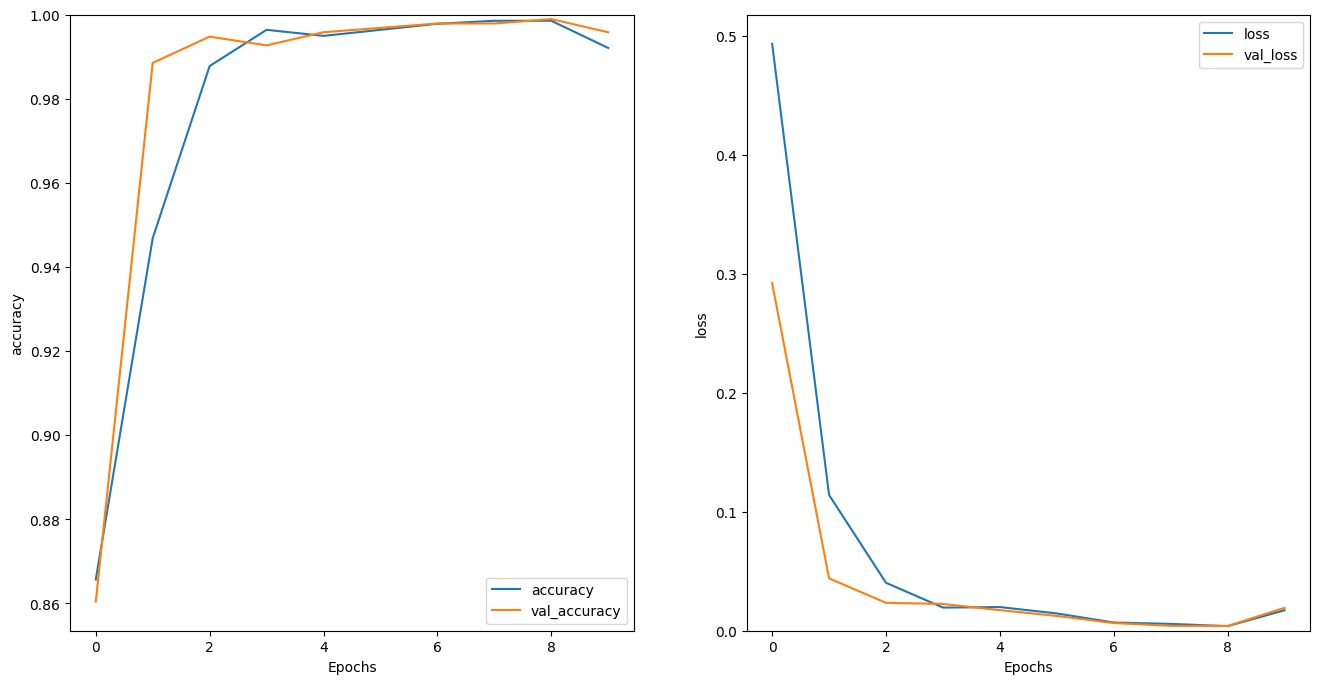

In [22]:
# Graphs
def plot_graphs(h, metric):
    plt.plot(h.history[metric])
    plt.plot(h.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [23]:
h = history.history
print(h['loss'])
print(h['val_loss'])
print(h['accuracy'])
print(h['val_accuracy'])

[0.4935355484485626, 0.11417272686958313, 0.040304407477378845, 0.01945619098842144, 0.019899951294064522, 0.014530849643051624, 0.006917791906744242, 0.005756731610745192, 0.0038432280998677015, 0.017189577221870422]
[0.29231730103492737, 0.044019244611263275, 0.02346871979534626, 0.02249932661652565, 0.017302175983786583, 0.012420819140970707, 0.00644723791629076, 0.004117742646485567, 0.003995425533503294, 0.01921183429658413]
[0.8656609058380127, 0.9468390941619873, 0.9877873659133911, 0.9964080452919006, 0.9949712753295898, 0.9964080452919006, 0.9978448152542114, 0.9985632300376892, 0.9985632300376892, 0.9920976758003235]
[0.8604166507720947, 0.9885416626930237, 0.9947916865348816, 0.9927083253860474, 0.9958333373069763, 0.996874988079071, 0.9979166388511658, 0.9979166388511658, 0.9989583492279053, 0.9958333373069763]


In [24]:
# function to predict messages based on model
def predict_message(pred_text):
    ps = model.predict([pred_text])
    print(ps)
    p = ps[0][0]
    return [p, "ham" if p <0.5 else "spam"]

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 5s 5s/step
[[-12.684866]]
[-12.684866, 'ham']


In [25]:
# Run this cell to test your function and model.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 135ms/step
[[-12.684866]]
1/1 [==============================] - 0s 131ms/step
[[4.17213]]
1/1 [==============================] - 0s 130ms/step
[[-12.478833]]
1/1 [==============================] - 0s 139ms/step
[[5.5335217]]
1/1 [==============================] - 0s 138ms/step
[[7.6506352]]
1/1 [==============================] - 0s 137ms/step
[[-14.447166]]
1/1 [==============================] - 0s 138ms/step
[[-11.508619]]
You passed the challenge. Great job!
